In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sympy as sp
import h5py

from scipy.integrate import quad
from scipy.io import loadmat

In [2]:
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rcParams['text.usetex']: True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
os.getcwd()

'/mnt/c/Users/admin/Documents/workspace/fyp'

# Acoustic Modes

The general matrix method will be solved for an open-open duct with no mean flow, assuming harmoic vibrations

$$ \mathbf{M} \begin{bmatrix} A \\ B \end{bmatrix} = \mathbf{0} $$

where 

$$ \mathbf{M} = \begin{bmatrix} 1 & -R_{u} \\ R_{d}exp\left(-\frac{i\omega L}{\bar{c}} \right) & -exp\left(\frac{i\omega L}{\bar{c}} \right) \end{bmatrix} $$


The aim is to solve for $\omega$ such that $det(\mathbf{M}) = 0$

In [4]:
j = complex(0, 1)
e = np.e

In [131]:
class AcousticModel:
    gamma = 1.4
    Rg = 287
    def __init__(self, L, n):
        self.L = L
        self.n = n
        self.x = np.linspace(0, self.L, self.n+1)
        
        
    def _p_fluc(self, k, boundary = 0):
        '''
        Returns pressure fluctuations within duct.
        Two different return values possible, depending on which 
        boundary condition is chosen. 
        Boundary=0 for boundary condition at x=0 (default), Boundary=1
        for boundary at x=L. In the simplest case, both should return
        the same values. 
        '''
        
        self._x = np.linspace(0, self.L, self.n+1)[..., np.newaxis]
        
        if boundary == 0:
            return e**((-j*k*self._x)) + 1/self.Ru*e**(j*k*self._x) # using BC and x = 0
        elif boundary == 1:
            return e**((-j*k*self._x)) + self.Rd*e**(-2*j*k*self.L)*e**(j*k*self._x) # using BC at x = L
        
        
    def general_matrix_method(self, Ru, Rd, c=345):
        ''' Uses the general matrix method to find the acoustic modes of a simple duct'''
        self.c = c
        self.Ru = Ru
        self.Rd = Rd
        
        def _matrix_det(w, Ru, Rd):
            det = -sp.exp(j*w*self.L/self.c) + Rd*Ru*sp.exp(-j*w*self.L/self.c)
            return det
        
        self._w = sp.Symbol('w')
        print('Solving for general matrix method..')
        # Solving for w for which the determinent of the matrix is 0
        self.w1 = sp.solveset(_matrix_det(self._w, Ru, Rd), self._w, domain=sp.S.Complexes)
        print('General solution:')
        sp.pprint(self.w1)
        
        self._w1_iter = iter(self.w1)
        self._w1_all = [complex(next(iter(self._w1_iter))) for i in range(10)]
        self.wn = [self._w1_all[i] for i in range(len(self._w1_all)) if (i%2==1)]
        self.wn = np.asarray(self.wn)
        self.k = self.wn/self.c
        
    
    def get_pressure_fluctuations(self, num_nodes=3):
        return self._p_fluc(self.k[:num_nodes])
    
    
    def _plot_pressure_fluctuations(self, p_fluc, labels):
        plt.plot(self.x, np.abs(p_fluc), label = labels)
        plt.ylabel('|p\'|')
        plt.xlabel('Length')
        plt.legend(loc='upper left')
        plt.show()
    
    
    def plot_acoustic_modes(self, num_nodes=3):
        self._p_dash = self.get_pressure_fluctuations(num_nodes)
        self._plot_pressure_fluctuations(self._p_dash, [f'Mode: {i+1}' for i in range(num_nodes)])      

In [132]:
test = AcousticModel(0.75, 100)
test.general_matrix_method(-1, -1)

Solving for general matrix method..
General solution:
{460.0⋅n⋅π │ n ∊ ℤ}


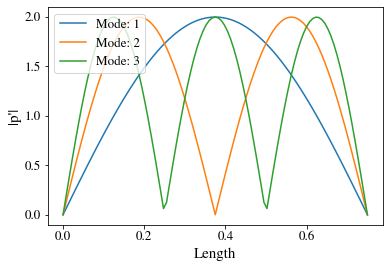

In [133]:
test.plot_acoustic_modes()

# Viscous Effects and Non-Reflective Boundary Conditions

The assumptions for this viscous model are: 
- Low frequency, i.e. $kR_t<<1$
- High shear numbers, i.e. $Sh = R_t\left(\frac{\omega}{\nu}\right)^{\frac{1}{2}}>>1$

Where $R_t$ is the radius of the pipe

In [134]:
# Implement function to get different properties of air at various temperatures? But not necessary
def get_properties(T):
    '''Calculates Properties of air at 1 atm'''
    p = 101325 # Pa
    Rg = 287 # Jkg-1K-1
    # Density
    rho = p/(Rg*T)
    
    # Dynamic Viscosity
    if (100 <= T <= 1000):
        dyn_visc = 1.716e-5*(T/273.15)**(3/2)*383.55/(T+110.4)
    elif(1000 <= T <= 3000):
        dyn_visc = 2.653e-8*T+1.573e-5
        
    # Kinematic viscosity
    kin_visc = dyn_visc/rho
    
def Dynamic_viscosity(T):
    '''
    Dynamic viscosity of air as a function of temperature.
    Estimated by Sutherland's Law. 
    '''
    if (100 <= T <= 1000):
        return 1.716e-5*(T/273.15)**(3/2)*383.55/(T+110.4)
    elif(1000 <= T <= 3000):
        return 2.653e-8*T+1.573e-5

In [135]:
class ViscousModel(AcousticModel):
    def __init__(self, L, n, Ru, Rd, Rt, T, w=None):
        super().__init__(L, n)
        self.Rt = Rt
        self.Ru = Ru
        self.Rd = Rd
        self.T = T
        self.Cp = 1175
        self.Pr = 0.72
        self.dyn_visc = Dynamic_viscosity(self.T)
        self.rho = 0.29
        self.kin_visc = self.dyn_visc/self.rho
        self.c = np.sqrt(self.gamma * self.Rg * self.T)
        self.w = w if w else 2*np.pi*self.c/self.L
        self.k = self.w/self.c
        self.Sh = self.Rt * (self.w/self.kin_visc)**0.5
        
    
    def _k_correction(self):
        self.kc = self.w/self.c*(1+(1-j)/np.sqrt(2)/self.Sh*(1+(self.gamma-1)/(self.Pr**(1/2)))-j/(self.Sh**2)*(1+(self.gamma-1)/(self.Pr**(1/5))-self.gamma/2*(self.gamma-1)/self.Pr))
        
    
    def get_pressure_fluctuations(self):
        self._k_correction()
        return super()._p_fluc(self.kc)
    
    
    def plot_damped(self):
        self._k_correction()
        self._ks = np.array([self.k, self.kc])
        self._p_fluc = super()._p_fluc(self._ks)
        super()._plot_pressure_fluctuations(self._p_fluc, ['Original', 'Damped'])
        
        
    def plot_non_reflective_bc(self):
        self._k_correction()
        self._a = np.real(self.kc)
        self._b = np.imag(self.kc)
        self._p_orig1 = np.cos(-self.w/self.c*self.x)
        self._p_damping1 = np.exp(self._b*self.x)*np.cos(-self._a*self.x)
        self._data1 = np.vstack([self._p_orig1, self._p_damping1]).T
        
        self.xtmp = np.linspace(0, -self.L, 1000)
        self._p_orig2 = np.cos(self.w/self.c*self.xtmp)
        self._p_damping2 = np.exp(-self._b*self.xtmp)*np.cos(self._a*self.xtmp)
        self._data2 = np.vstack([self._p_orig2, self._p_damping2]).T
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.x, self._data1, label = ['Original', 'Damping correction'])
        ax2.plot(self.xtmp + self.L, self._data2, label = ['Original', 'Damping correction'])
        ax1.set_xlabel('length (m)')
        ax2.set_xlabel('length (m)')
        ax1.legend(['Original', 'Damped'], loc = 'lower left')
        ax2.legend(['Original', 'Damped'], loc = 'lower left')
        ax1.set_ylabel('|p\'|')
        ax2.set_ylabel('|p\'|')
        ax1.set_title('Upstream')
        ax2.set_title('Downstream')
        fig.suptitle('Non-Reflective Boundary Conditions', fontsize=20)
        fig.show()

In [136]:
test2 = ViscousModel(0.75, 10000, -1, 0, 0.005, 950, 10000)

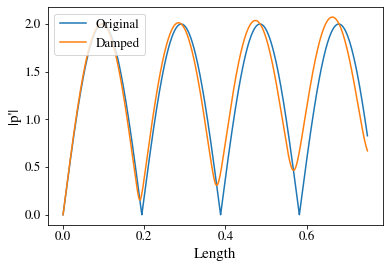

In [137]:
test2.plot_damped()

In [129]:
test2.plot_non_reflective_bc()

NameError: name 'test2' is not defined

# Temperature Gradient Modelling

User specifies:
- Temperature gradient (linear or sinusoidal) or arbitrary heat release rate
- Arbitrary inlet conditions

Set of differential equations:

$$\frac{d\bar{u}}{dx} = -\bar{u}\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\frac{d\bar{p}}{dx} = \bar{\rho}\bar{u}^2\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\bar{\dot{q}}=\bar{\rho}\bar{u}\left(c_p\frac{d\bar{T}}{dx}+\bar{u}\frac{d\bar{u}}{dx}\right)$$

$$\frac{1}{\bar{T}}\frac{d\bar{T}}{dx}=\frac{1}{\bar{p}}\frac{d\bar{p}}{dx}-\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}=-(1-\gamma M^2)\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\frac{1}{\bar{c}}\frac{d\bar{c}}{dx}=\frac{1}{2\bar{T}}\frac{d\bar{T}}{dx}=-\frac{1-\gamma M^2}{2}\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\frac{dM}{d\bar{x}}=\frac{1}{\bar{c}}\frac{d\bar{u}}{dx}-\frac{M}{\bar{c}}\frac{d\bar{c}}{dx}=-\frac{M(1+\gamma M^2)}{2}\alpha$$


In [380]:
class TemperatureGradientModel:
    gamma = 1.4
    Rg = 287
    Rt = 0.001
    def __init__(self, L, x1, n, p1, M1, T1, T2, temp_dist = 'lin', Z1 = -1, fl_c = 1, viscous_effects=False):
        self.L = L
        self.x1 = x1
        self.p1 = p1
        self.x = np.linspace(x1, L, n)
        self.dx = self.x[1] - self.x[0]
        self.M1 = M1
        self.T1 = T1
        self.T2 = T2
        self.Z1 = Z1
        self.temp_dist = temp_dist
        self.fl_c = fl_c
        
        if self.temp_dist == 'lin':
            self.T = self.T1 + (self.T2-self.T1)/self.L*(self.x-self.x1)

        elif self.temp_dist == 'sin':
            self.T = (self.T1-self.T2)/2*np.sin(5*np.pi/4*(self.x-self.x1)/self.L + np.pi/4)+(self.T1+self.T2)/2

        self.c1 = np.sqrt(self.gamma * self.Rg * self.T[0])
        self.u1 = self.M1 * self.c1
        self.rho1 = self.p1/(self.Rg*self.T[0])
        
        self.A = self.rho1*self.u1
        self.B = self.p1 + self.rho1*self.u1**2
        
        self.w = self.fl_c*2*np.pi*self.c1/self.L
        self.viscous_effects = viscous_effects
        
    def calculate(self):
        self.calculate_mean_properties()
        self.calculate_flow_properties()
        
    
    def _grad(self, q):
        dqdx = np.zeros(q.shape)
        dqdx[1:-1] = (q[2:]-q[:-2])/(2*self.dx)
        dqdx[0] = (q[1]-q[0])/self.dx
        dqdx[-1] = (q[-1]-q[-2])/self.dx
        return dqdx
        
        
    def calculate_mean_properties(self):
        self.c = np.sqrt(self.gamma * self.Rg * self.T)
        self.u = (self.B/self.A - np.sqrt((self.B/self.A)**2 - 4*self.Rg * self.T))/2
        self.rho = self.A/self.u
        self.p = self.rho*self.Rg*self.T
        self.M = self.u/self.c
        self.alpha = 1/self.rho*self._grad(self.rho)
        
        def Dynamic_viscosity(T):
            if (100 <= T <= 1000):
                return 1.716e-5*(T/273.15)**(3/2)*383.55/(T+110.4)
            elif(1000 < T <= 3000):
                return 2.653e-8*T+1.573e-5
        
        self.v = np.array([Dynamic_viscosity(t) for t in self.T])/self.rho
        self.Pr = 0.71
        self.Sh = self.Rt * (self.w/self.v)**0.5
        
        if self.viscous_effects:
            self.k0 = self.w/(self.c*(1+self.M))*(1+(1-j)/np.sqrt(2)/self.Sh*(1+(self.gamma-1)/(self.Pr**(1/2)))-j/(self.Sh**2)*(1+(self.gamma-1)/(self.Pr**(1/2))-self.gamma/2*(self.gamma-1)/self.Pr))
        else:
            self.k0 = self.w/self.c
        return
    
    
    def plot_mean_properties(self):
        return
        
        
    def _numerical_integration(self):
        
        def c_T(T):
            return np.sqrt(self.gamma*self.Rg*T)

        def u_T(T):
            return (self.B/self.A - np.sqrt((self.B/self.A)**2-4*self.Rg*T))/2

        def T_x(x):
            if self.temp_dist == 'lin':
                return self.T1+(self.T2-self.T1)*(x-self.x1)/self.L
            else:
                return (self.T1-self.T2)/2*np.sin(5*np.pi/4*(x-self.x1)/self.L + np.pi/4)+(self.T1+self.T2)/2
        
        def integrand_plus(x):
            return 1/(c_T(T_x(x)) + u_T(T_x(x)))

        def integrand_minus(x):
            return 1/(c_T(T_x(x)) - u_T(T_x(x)))
        
        def integral_plus(x):
            return quad(integrand_plus, self.x1, x)[0]

        def integral_minus(x):
            return quad(integrand_minus, self.x1, x)[0]
        
        self.integrals_plus = np.array([integral_plus(value) for value in self.x])
        self.integrals_minus = np.array([integral_minus(value) for value in self.x])
        
    
    def _get_intermediate_vals(self, rho, M, rho1, M1, gamma, w, c, alpha, integrals_plus, integrals_minus):
        self.P1_plus = (rho/rho1)**(1/4)*(1+M1)/(1+M)*(np.exp(gamma*M1-gamma/4*M1**2-(gamma**2-1)/3*M1**3))/(np.exp(gamma*M-gamma/4*M**2-(gamma**2-1)/3*M**3))*np.exp(-j*w*integrals_plus)
        self.P1_minus= (rho/rho1)**(1/4)*(1-M1)/(1-M)*(np.exp(gamma*M+gamma/4*M**2-(gamma**2-1)/3*M**3))/(np.exp(gamma*M1+gamma/4*M1**2-(gamma**2-1)/3*M1**3))*np.exp(j*w*integrals_minus)
        self.K1 = (j*self.k0-(1+2*(1+gamma)*M+(3*gamma-7)*M**2)*alpha/4)/(j*self.k0-alpha*M)
        self.K2 = (j*self.k0+(1-2*(1+gamma)*M+(3*gamma-7)*M**2)*alpha/4)/(j*self.k0-alpha*M)
        
        
    def _get_flow_properties(self, C1_plus, C1_minus, P1_plus, P1_minus, K1, K2, rho, c):
        self.p_hat = C1_plus*P1_plus + C1_minus*P1_minus
        self.u_hat = K1*C1_plus*P1_plus/(rho*c) - K2*C1_minus*P1_minus/(rho*c)
        self.Fp = self.p_hat/(rho[0]*c[0]*self.u_hat[0])
        self.Fu = self.u_hat/self.u_hat[0]
        
    
    def calculate_flow_properties(self):
        self._numerical_integration()
        self._get_intermediate_vals(self.rho, self.M, self.rho1, self.M1, self.gamma, self.w, self.c, self.alpha, self.integrals_plus, self.integrals_minus)
        
        # Initial conditions don't matter, plots later on are initialised
        # self.p0 = 100
        # self.u0 = self.p0/(self.rho[0]*self.c[0]*self.Z1)
        
        self.u0 = 1
        self.p0 = self.rho[0] * self.c[0] * self.Z1 * self.u0
        
        self.C1_plus = self.p0*(self.K2[0] + 1/self.Z1)/(self.K1[0] + self.K2[0])
        self.C1_minus = self.p0*(self.K1[0] - 1/self.Z1)/(self.K1[0] + self.K2[0])
        
        self._get_flow_properties(self.C1_plus, self.C1_minus, self.P1_plus, self.P1_minus, self.K1, self.K2, self.rho, self.c)
        
        
    def plot_flow_properties(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (14, 8))
        ax1.plot(self.x/self.L, abs(self.Fp))
        ax2.plot(self.x/self.L, abs(self.Fu))
        ax3.plot(self.x/self.L, np.angle(self.Fp)/np.pi)
        ax4.plot(self.x/self.L, np.angle(self.Fu)/np.pi)
        ax1.set_xlabel('x/l')
        ax2.set_xlabel('x/l')
        ax3.set_xlabel('x/l')
        ax4.set_xlabel('x/l')
        ax1.set_ylabel('|Fp|')
        ax2.set_ylabel('|Fu|')
        ax3.set_ylabel('<Fp/pi')
        ax4.set_ylabel('<Fu/pi')
        fig.show()

In [381]:
def plot_results(model, valid_data = [], legend=[]):
    fig, ax = plt.subplots(2, 2, figsize = (10, 6), constrained_layout=True, sharex=True)
    markers = ['^b--', 'k-', 'pg--', 'xr--', 'ok--']
    x = model.x
    model_data = {'Fp': model.Fp, 'Fu': model.Fu}
    data = [model_data] + valid_data
    for i, data in enumerate(data):
        ax[0][0].plot(x, abs(data['Fp']), markers[i], fillstyle='none', markevery=50)
        ax[1][0].plot(x, np.angle(data['Fp'])/np.pi, markers[i], fillstyle='none', markevery=50)
        ax[0][1].plot(x, abs(data['Fu']), markers[i], fillstyle='none', markevery=50)
        ax[1][1].plot(x, np.angle(data['Fp'])/np.pi, markers[i], fillstyle='none', markevery=50)
        
    ax[0][0].set_ylabel(r'$|F_P|$')
    ax[1][0].set_ylabel(r'$\angle F_P / \pi$')
    ax[1][0].set_xlabel(r'$x/L$')
    ax[1][1].set_ylabel(r'$\angle F_u / \pi$')
    ax[1][1].set_xlabel(r'$x/L$')
    ax[0][1].set_ylabel(r'$|F_u|$')

    ax[0][1].legend(legend)

In [382]:
lin_model = TemperatureGradientModel(L = 1, x1 = 0, n = 2001, p1 = 1e5, M1 = 0.2, T1 = 1600, T2 = 800, temp_dist = 'lin', Z1 = -1, fl_c = 1, viscous_effects=False)
lin_model.calculate()
sin_model = TemperatureGradientModel(L = 1, x1 = 0, n = 2001, p1 = 1e5, M1 = 0.2, T1 = 1600, T2 = 800, temp_dist = 'sin', Z1 = -1, fl_c = 1.5, viscous_effects=False)
sin_model.calculate()
sin_model2 = TemperatureGradientModel(L = 1, x1 = 0, n = 2001, p1 = 1e5, M1 = 0.2, T1 = 1600, T2 = 800, temp_dist = 'sin', Z1 = -1, fl_c = 1, viscous_effects=False)
sin_model2.calculate()

In [411]:
# Validation dataset
valid_sin = loadmat('./matlab/sin_f150_M_020_new.mat')
valid_sin2 = loadmat('./matlab/sin_f100_M_020_new.mat')
valid_lin = loadmat('./matlab/lin_f100_M_020_new.mat')
valid_pietro_lin_raw = loadmat('./matlab_pietro/Tlin1600-800.mat')
valid_pietro_sin_raw = loadmat('./matlab_pietro/Tsin1600-800.mat')

In [412]:
sin_mean = valid_sin['TP'][0,0]
lin_mean = valid_lin['TP'][0,0]

In [413]:
valid_pietro_lin = {'Fp': valid_pietro_lin_raw['Fp'][0], 'Fu': valid_pietro_lin_raw['Fu'][0]}
valid_pietro_sin = {'Fp': valid_pietro_sin_raw['Fp'][0], 'Fu': valid_pietro_sin_raw['Fu'][0]}

In [414]:
lin_wkb = {'Fp': valid_lin['Fp_WKB'][0], 'Fu': valid_lin['Fu_WKB'][0]}
lin_LEE = {'Fp': valid_lin['Fp_LEE'][0], 'Fu': valid_lin['Fu_LEE'][0]}

sin_wkb = {'Fp': valid_sin['Fp_WKB'][0], 'Fu': valid_sin['Fu_WKB'][0]}
sin_LEE = {'Fp': valid_sin['Fp_LEE'][0], 'Fu': valid_sin['Fu_LEE'][0]}

sin_wkb2 = {'Fp': valid_sin2['Fp_WKB'][0], 'Fu': valid_sin2['Fu_WKB'][0]}
sin_LEE2 = {'Fp': valid_sin2['Fp_LEE'][0], 'Fu': valid_sin2['Fu_LEE'][0]}

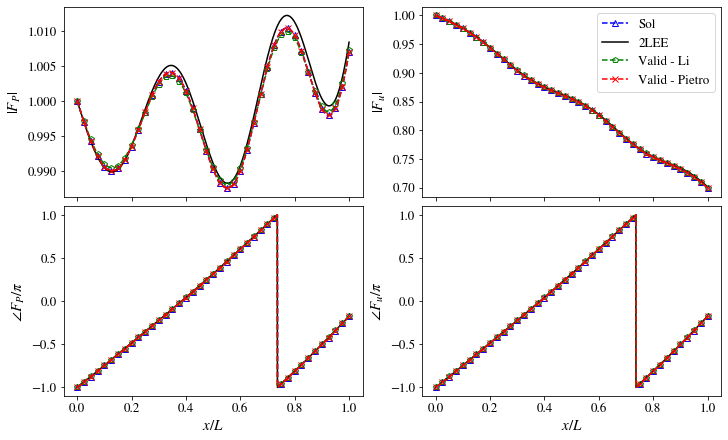

In [415]:
plot_results(lin_model, [lin_LEE, valid_pietro_lin, lin_wkb], ['Sol', '2LEE', 'Valid - Li', 'Valid - Pietro'])

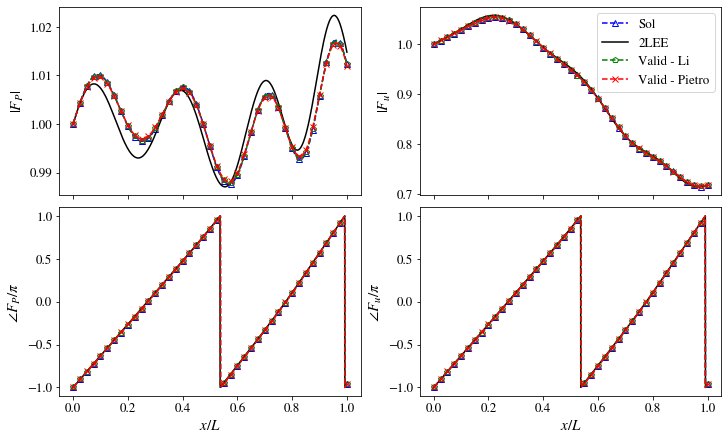

In [416]:
plot_results(sin_model, [sin_LEE, sin_wkb, valid_pietro_sin], ['Sol', '2LEE', 'Valid - Li', 'Valid - Pietro'])

# Temperature Gradient and Damping model

In [424]:
valid_pietro_lin_damping_raw = loadmat('./matlab_pietro/Tlin1600-800_damping.mat')
valid_pietro_sin_damping_raw = loadmat('./matlab_pietro/Tsin1600-800_damping.mat')

valid_pietro_lin_damping = {'Fp': valid_pietro_lin_damping_raw['Fp_c'][0], 'Fu': valid_pietro_lin_damping_raw['Fu_c'][0]}
valid_pietro_sin_damping = {'Fp': valid_pietro_sin_damping_raw['Fp_c'][0], 'Fu': valid_pietro_sin_damping_raw['Fu_c'][0]}

In [425]:
lin_model_damping = TemperatureGradientModel(L = 1, x1 = 0, n = 2001, p1 = 1e5, M1 = 0.2, T1 = 1600, T2 = 800, temp_dist = 'lin', Z1 = -1, fl_c = 1, viscous_effects=True)
lin_model_damping.calculate()
sin_model_damping = TemperatureGradientModel(L = 1, x1 = 0, n = 2001, p1 = 1e5, M1 = 0.2, T1 = 1600, T2 = 800, temp_dist = 'sin', Z1 = -1, fl_c = 1.5, viscous_effects=True)
sin_model_damping.calculate()

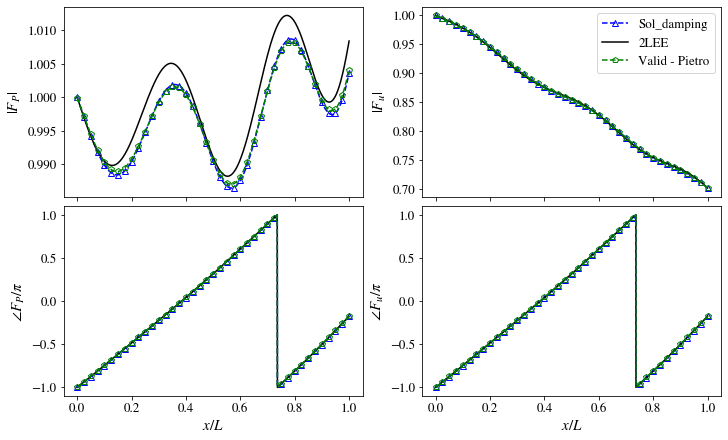

In [426]:
plot_results(lin_model_damping, [lin_LEE, valid_pietro_lin_damping], ['Sol_damping', '2LEE', 'Valid - Pietro'])

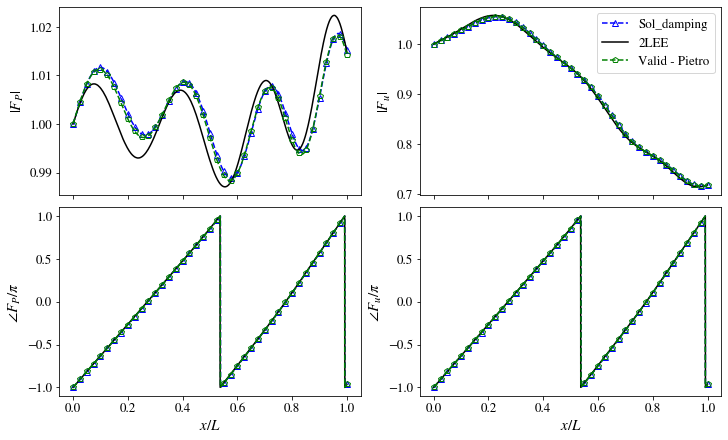

In [427]:
plot_results(sin_model_damping, [sin_LEE, valid_pietro_sin_damping], ['Sol_damping', '2LEE', 'Valid - Pietro'])